In [21]:
import pandas as pd

import django, sys, os
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [22]:
# outer fold for SVM results
results = []
for rank_i in range(5):
    results += pd.read_csv(f'../data/cv_results/svm_outer_{rank_i}.csv').to_dict('results')
svm_df = pd.DataFrame.from_dict(results)
svm_df['model'] = "SVM"

print(svm_df.shape)
svm_df.head()

(5, 12)


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/frame.py:1487: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


,ROC AUC,F1,precision,recall,accuracy,clf__C,clf__kernel,vect__max_df,vect__min_df,vect__ngram_range,rank_k,model
0,0.889186,0.714286,0.675676,0.757576,0.851852,1,linear,0.75,20,"(1, 2)",0,SVM
1,0.851347,0.538462,0.608696,0.482759,0.837838,1,linear,0.75,10,"(1, 2)",1,SVM
2,0.857698,0.612245,0.600000,0.625000,0.866197,1,linear,0.50,10,"(1, 2)",2,SVM
3,0.859288,0.655738,0.666667,0.645161,0.857143,1,linear,1.00,10,"(1, 2)",3,SVM
4,0.845763,0.557377,0.447368,0.739130,0.831250,1,linear,1.00,10,"(1, 2)",4,SVM


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('../data/0_labelled_documents.csv')

vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.75, strip_accents='unicode', 
    max_features=20000,)

X = vec.fit_transform(df['content'].astype("str"))   

In [24]:
from sklearn.svm import SVC

clf = SVC(C=0.75, probability=True)
clf.fit(X,df['relevant'])

SVC(C=0.75, probability=True)

In [25]:
q = Query.objects.get(pk=9035)
new_docs = Doc.objects.filter(query=q)
unseen_df = pd.DataFrame.from_dict(new_docs.values('id','title','content','tslug'))
unseen_df.head()

,id,title,content,tslug
0,311299,Environmental and resource constraints on Asia...,"In industrialising countries, personal income ...",environmentalandresourceconstraintsonasianurba...
1,393227,No change from climate change: vulnerability a...,Climate change is frequently touted as the big...,nochangefromclimatechangevulnerabilityandsmall...
2,376852,Stakeholder Perceptions of Seaport Resilience ...,Climate change is having and will continue to ...,stakeholderperceptionsofseaportresiliencestrat...
3,16405,Changes in population susceptibility to heat a...,Background: In the context of a warming climat...,changesinpopulationsusceptibilitytoheatandcold...
4,786455,Managing Climate Change Risks in Africa - A Gl...,Africa is projected to experience diverse and ...,managingclimatechangerisksinafricaaglobalpersp...


In [26]:
pred_X = vec.transform(unseen_df['content'].astype("str"))   

y_pred = clf.predict_proba(pred_X)

unseen_df['prediction'] = y_pred[:,1]

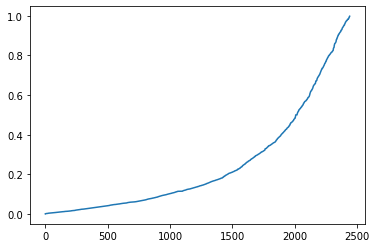

In [31]:
import matplotlib.pyplot as plt
plt.plot(unseen_df.sort_values('prediction').reset_index()['prediction'])

In [38]:
tag, created = Tag.objects.get_or_create(
    query=q,
    title="Ordered"
)

u = User.objects.get(username='olivia.serdeczny@climateanalytics.org')

for i, row in unseen_df.sort_values('prediction',ascending=False).reset_index().iterrows():
    doc = Doc.objects.get(pk=row['id'])
    doc.tag.add(tag)
    do, created = DocOwnership.objects.get_or_create(
        doc=doc,
        tag=tag,
        query=q,
        user=u,
        order=i
    )

In [39]:
tag.update_tag()